In [14]:
import os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path('/content/drive/MyDrive')
DATA_DIR = PROJECT_ROOT / 'ml-25m'
FIG_DIR = PROJECT_ROOT / 'figs'
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [15]:
def load_if_needed():
    """Load ratings/movies if not already in memory."""
    glb = globals()
    if 'ratings' in glb and 'movies' in glb:
        return glb['ratings'], glb['movies']
    r = pd.read_csv(DATA_DIR/'ratings.csv',
                    usecols=['userId','movieId','rating','timestamp'],
                    dtype={'userId':'int32','movieId':'int32','rating':'float32','timestamp':'int64'},
                    engine='pyarrow')
    m = pd.read_csv(DATA_DIR/'movies.csv',
                    usecols=['movieId','title','genres'],
                    dtype={'movieId':'int32','title':'string','genres':'string'},
                    engine='pyarrow')
    return r, m

ratings, movies = load_if_needed()

### 1) Popularity distribution per movie + Gini/HHI

In [16]:
ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year.astype('Int16')

movie_pop = ratings.groupby('movieId').size().rename('n_ratings').reset_index()
pop_values = movie_pop['n_ratings'].values

def gini_coefficient(x: np.ndarray) -> float:
    x = x.astype(np.float64)
    if np.amin(x) < 0:
        x -= np.amin(x)
    mean_x = np.mean(x)
    if mean_x == 0:
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    gini = (n + 1 - 2*np.sum(cum)/cum[-1]) / n
    return float(gini)

def hhi_from_counts(counts: np.ndarray) -> float:
    s = counts / counts.sum()
    return float(np.sum(s*s))

def topk_share(counts: np.ndarray, k_ratio=0.01) -> float:
    k = max(1, int(len(counts) * k_ratio))
    top = np.sort(counts)[::-1][:k]
    return float(top.sum() / counts.sum())

print("[Popularity stats]")
print(f"Gini = {gini_coefficient(pop_values):.3f}, HHI = {hhi_from_counts(pop_values):.5f}")
print(f"Top1%={topk_share(pop_values,0.01):.3f}, Top5%={topk_share(pop_values,0.05):.3f}, Top10%={topk_share(pop_values,0.10):.3f}")

[Popularity stats]
Gini = 0.942, HHI = 0.00060
Top1%=0.476, Top5%=0.845, Top10%=0.940


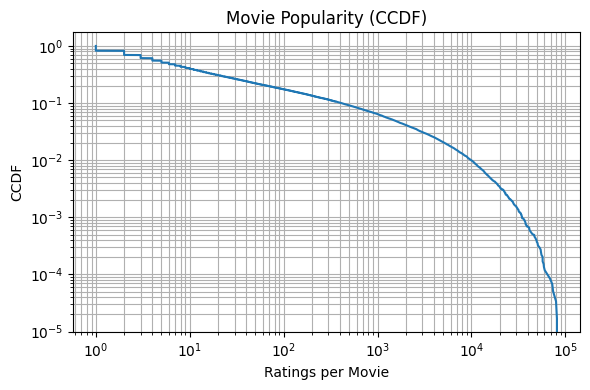

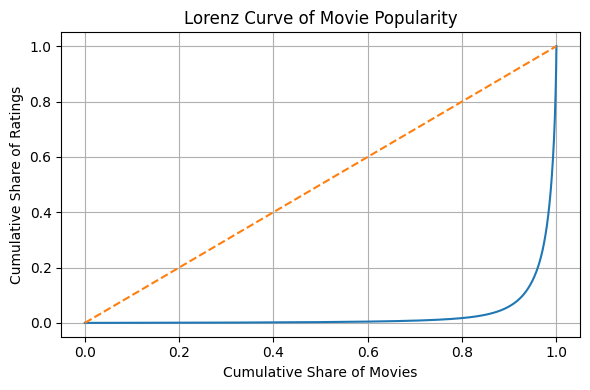

In [17]:
# CCDF
vals = np.sort(pop_values)
ccdf = 1.0 - np.arange(1, len(vals)+1)/len(vals)
plt.figure(figsize=(6,4))
plt.loglog(vals, ccdf)
plt.xlabel('Ratings per Movie'); plt.ylabel('CCDF')
plt.title('Movie Popularity (CCDF)')
plt.grid(True, which='both')
plt.tight_layout(); plt.savefig(FIG_DIR/'popularity_ccdf.png', dpi=150); plt.show()

# Lorenz
cum_pop = np.cumsum(vals)
lorenz = np.insert(cum_pop/cum_pop[-1], 0, 0)
x_lor = np.linspace(0, 1, len(lorenz))
plt.figure(figsize=(6,4))
plt.plot(x_lor, lorenz)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('Cumulative Share of Movies'); plt.ylabel('Cumulative Share of Ratings')
plt.title('Lorenz Curve of Movie Popularity')
plt.grid(True); plt.tight_layout(); plt.savefig(FIG_DIR/'lorenz_popularity.png', dpi=150); plt.show()

### 2) User entropy distribution & vs activity

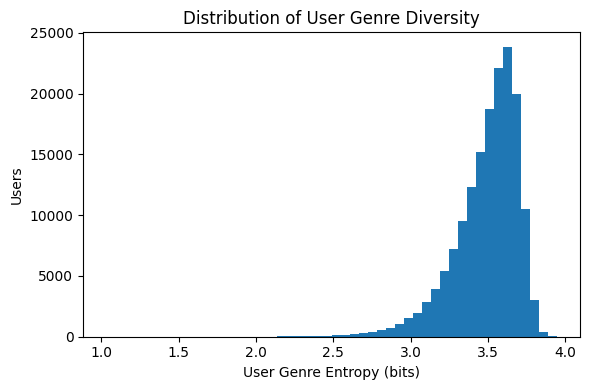

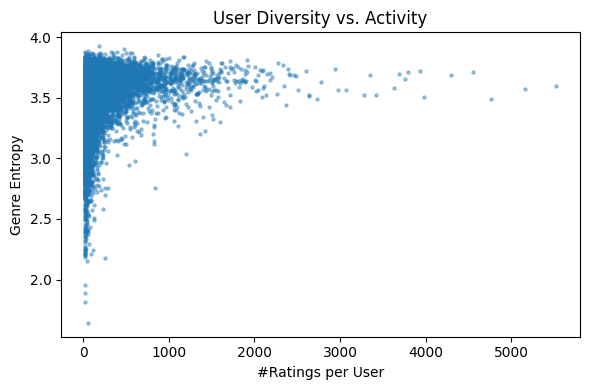

In [18]:
def split_genres(g):
    if pd.isna(g) or g=='(no genres listed)':
        return []
    return str(g).split('|')

movie_genres = movies[['movieId','genres']].copy()
movie_genres['genre_list'] = movie_genres['genres'].apply(split_genres)

ratings_g = ratings.merge(movie_genres[['movieId','genre_list']], on='movieId', how='left')
ratings_g = ratings_g.explode('genre_list').dropna(subset=['genre_list'])

user_genre_counts = ratings_g.groupby(['userId','genre_list']).size().rename('cnt').reset_index()
user_tot = user_genre_counts.groupby('userId')['cnt'].sum().rename('tot')
user_genre_p = user_genre_counts.merge(user_tot, on='userId')
user_genre_p['p'] = user_genre_p['cnt']/user_genre_p['tot']

def shannon_entropy(prob: np.ndarray, eps=1e-12) -> float:
    p = prob[prob>0]
    return float(-np.sum(p*np.log2(p+eps)))

user_entropy = user_genre_p.groupby('userId')['p'].apply(lambda p: shannon_entropy(p.values)).rename('genre_entropy').reset_index()
user_n = ratings.groupby('userId').size().rename('n_ratings').reset_index()
user_stats = user_n.merge(user_entropy, on='userId', how='left')

plt.figure(figsize=(6,4))
plt.hist(user_stats['genre_entropy'].dropna().values, bins=50)
plt.xlabel('User Genre Entropy (bits)'); plt.ylabel('Users')
plt.title('Distribution of User Genre Diversity')
plt.tight_layout(); plt.savefig(FIG_DIR/'user_entropy_hist.png', dpi=150); plt.show()

sample_users = user_stats.sample(n=min(20000, len(user_stats)), random_state=42)
plt.figure(figsize=(6,4))
plt.scatter(sample_users['n_ratings'], sample_users['genre_entropy'], s=5, alpha=0.4)
plt.xlabel('#Ratings per User'); plt.ylabel('Genre Entropy')
plt.title('User Diversity vs. Activity')
plt.tight_layout(); plt.savefig(FIG_DIR/'entropy_vs_activity.png', dpi=150); plt.show()

### 3) User-user similarity (sampled)

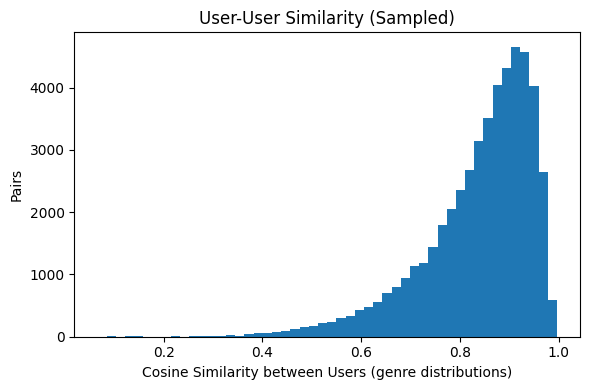

In [19]:

from collections import defaultdict
N_SAMPLE_USERS = 5000
sel_users = set(user_stats['userId'].sample(min(N_SAMPLE_USERS, len(user_stats)), random_state=7).values)
ug = user_genre_p[user_genre_p['userId'].isin(sel_users)].copy()
user_vec = defaultdict(dict)
for uid, g, p in ug[['userId','genre_list','p']].itertuples(index=False):
    user_vec[uid][g] = float(p)
sel_users = list(user_vec.keys())

def cosine_dict(d1, d2):
    if not d1 or not d2: return 0.0
    common = set(d1.keys()) & set(d2.keys())
    dot = sum(d1[k]*d2[k] for k in common)
    n1 = math.sqrt(sum(v*v for v in d1.values()))
    n2 = math.sqrt(sum(v*v for v in d2.values()))
    return 0.0 if (n1==0 or n2==0) else dot/(n1*n2)

pairs=50000; sims=[]
for _ in range(pairs):
    a,b = random.sample(sel_users,2)
    sims.append(cosine_dict(user_vec[a], user_vec[b]))

plt.figure(figsize=(6,4))
plt.hist(sims, bins=50)
plt.xlabel('Cosine Similarity between Users (genre distributions)'); plt.ylabel('Pairs')
plt.title('User-User Similarity (Sampled)')
plt.tight_layout(); plt.savefig(FIG_DIR/'user_similarity_hist.png', dpi=150); plt.show()

### 4) Yearly concentration

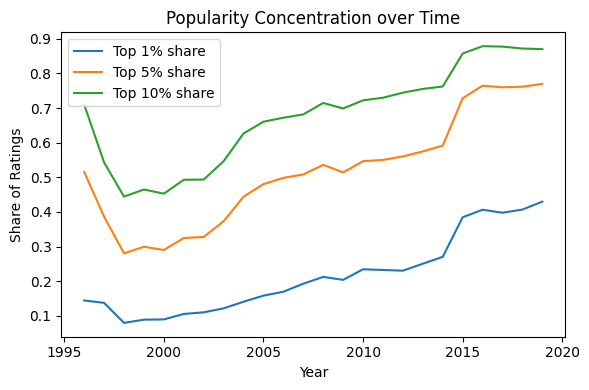

In [20]:

yearly = ratings.groupby('year')['movieId'].value_counts().rename('cnt').reset_index()
yearly = yearly[yearly['year'].notna() & (yearly['year']>=1995)]
def year_topk_share(df, k_ratio=0.01): return topk_share(df['cnt'].values, k_ratio)
agg_year=[]
for y, sub in yearly.groupby('year'):
    if len(sub)<50: continue
    agg_year.append({'year':int(y),
                     'top1p': year_topk_share(sub,0.01),
                     'top5p': year_topk_share(sub,0.05),
                     'top10p':year_topk_share(sub,0.10)})
agg_year = pd.DataFrame(agg_year).sort_values('year')

plt.figure(figsize=(6,4))
plt.plot(agg_year['year'], agg_year['top1p'], label='Top 1% share')
plt.plot(agg_year['year'], agg_year['top5p'], label='Top 5% share')
plt.plot(agg_year['year'], agg_year['top10p'], label='Top 10% share')
plt.xlabel('Year'); plt.ylabel('Share of Ratings'); plt.title('Popularity Concentration over Time')
plt.legend(); plt.tight_layout(); plt.savefig(FIG_DIR/'yearly_concentration.png', dpi=150); plt.show()

### A) dedup to earliest watch; pick old users; align first N interactions

In [21]:
ratings_sorted = ratings.sort_values(['userId','movieId','timestamp'])
ratings_first  = ratings_sorted.drop_duplicates(['userId','movieId'], keep='first')

u_agg = ratings_first.groupby('userId').agg(
    n=('movieId','size'),
    first_ts=('timestamp','min'),
    last_ts=('timestamp','max')
).reset_index()
u_agg['span_days'] = (pd.to_datetime(u_agg['last_ts'],unit='s') - pd.to_datetime(u_agg['first_ts'],unit='s')).dt.days

OLD_N=100; OLD_SPAN=180
old_users = u_agg[(u_agg['n']>=OLD_N) & (u_agg['span_days']>=OLD_SPAN)]['userId']
rf = ratings_first[ratings_first['userId'].isin(old_users)].copy()

movie_genres = movies[['movieId','genres']].copy()
movie_genres['genre_list'] = movie_genres['genres'].apply(split_genres)
rf = rf.merge(movie_genres[['movieId','genre_list']], on='movieId', how='left').explode('genre_list')
rf = rf.dropna(subset=['genre_list'])
rf = rf.sort_values(['userId','timestamp'])
rf['rank'] = rf.groupby('userId').cumcount() + 1
MAX_R=100
rf = rf[rf['rank']<=MAX_R].copy()
rf['year'] = pd.to_datetime(rf['timestamp'], unit='s').dt.year.astype('Int16')

### B) year-normalized novelty for next item

In [22]:

year_mov_cnt = ratings_first.copy()
year_mov_cnt['year'] = pd.to_datetime(year_mov_cnt['timestamp'], unit='s').dt.year.astype('Int16')
year_pop = year_mov_cnt.groupby(['year','movieId']).size().rename('cnt').reset_index()
year_tot = year_pop.groupby('year')['cnt'].sum().rename('tot').reset_index()
year_pop = year_pop.merge(year_tot, on='year', how='left')
year_pop['p'] = year_pop['cnt']/year_pop['tot']
pop_map = {(int(y),int(m)): float(p) for y,m,p in year_pop[['year','movieId','p']].itertuples(index=False)}
def novelty_year(movie_id, year):
    p = pop_map.get((int(year), int(movie_id)), 1e-12)
    return -np.log(p + 1e-12)

def next_novelty_user(df_user):
    out=[]; last_r = df_user['rank'].max()
    for r, mid, y in df_user[['rank','movieId','year']].itertuples(index=False):
        if r<last_r:
            nmid = df_user.loc[df_user['rank']==r+1, 'movieId'].values[0]
            ny   = df_user.loc[df_user['rank']==r+1, 'year'].values[0]
            out.append((r+1, novelty_year(nmid, ny)))
    return pd.DataFrame(out, columns=['rank','novelty_year'])
nov_all = rf.groupby('userId', group_keys=False).apply(next_novelty_user)
nov_agg = nov_all.groupby('rank').agg(mean=('novelty_year','mean'),
                                      median=('novelty_year','median'),
                                      count=('novelty_year','size')).reset_index()

/tmp/ipython-input-1679217498.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nov_all = rf.groupby('userId', group_keys=False).apply(next_novelty_user)


### C) rolling entropy (W=10), per user

In [23]:
def rolling_entropy_user(df_user, W=10):
    hist=[]; rows=[]
    for r, g in df_user[['rank','genre_list']].itertuples(index=False):
        hist.append(g)
        win = hist[-W:]
        c = Counter(win); tot = sum(c.values())
        p = np.array([v/tot for v in c.values()], dtype=float) if tot>0 else np.array([1.0])
        H = float(-np.sum(p*np.log2(p+1e-12)))
        rows.append((r,H))
    return pd.DataFrame(rows, columns=['rank','H_roll'])
W=10
roll_all = rf.groupby('userId', group_keys=False).apply(rolling_entropy_user, W=W)
roll_agg = roll_all.groupby('rank').agg(mean=('H_roll','mean'),
                                        median=('H_roll','median'),
                                        count=('H_roll','size')).reset_index()

/tmp/ipython-input-1038323395.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  roll_all = rf.groupby('userId', group_keys=False).apply(rolling_entropy_user, W=W)


### D) follow Top-2 prob (W=20), per user

In [24]:
def next_in_topk_user(df_user, K=2, W=20):
    rows=[]; last_r = df_user['rank'].max(); g_hist=[]
    for r, g in df_user[['rank','genre_list']].itertuples(index=False):
        g_hist.append(g)
        if r<last_r:
            win = g_hist[-W:]
            c = Counter(win)
            if not c:
                rows.append((r+1, np.nan)); continue
            topk = [t for t,_ in c.most_common(K)]
            ng = df_user.loc[df_user['rank']==r+1, 'genre_list'].values[0]
            rows.append((r+1, 1.0 if ng in topk else 0.0))
    return pd.DataFrame(rows, columns=['rank','next_in_top2'])
top2_all = rf.groupby('userId', group_keys=False).apply(next_in_topk_user, K=2, W=20)
top2_agg = top2_all.groupby('rank').agg(mean=('next_in_top2','mean'),
                                        count=('next_in_top2','size')).reset_index()

/tmp/ipython-input-1548022067.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top2_all = rf.groupby('userId', group_keys=False).apply(next_in_topk_user, K=2, W=20)


### E) cumulative entropy increments (ΔH) (illustrative)

In [25]:
def cum_entropy_incr_user(df_user):
    c=Counter(); out=[]; prev=0.0
    for r, g in df_user[['rank','genre_list']].itertuples(index=False):
        c[g]+=1; tot=sum(c.values())
        p = np.array([v/tot for v in c.values()], dtype=float)
        H = float(-np.sum(p*np.log2(p+1e-12)))
        out.append((r, H-prev)); prev=H
    return pd.DataFrame(out, columns=['rank','delta_H'])
dH_all = rf.groupby('userId', group_keys=False).apply(cum_entropy_incr_user)
dH_agg = dH_all.groupby('rank').agg(mean=('delta_H','mean'),
                                    median=('delta_H','median'),
                                    count=('delta_H','size')).reset_index()

/tmp/ipython-input-1221633499.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dH_all = rf.groupby('userId', group_keys=False).apply(cum_entropy_incr_user)


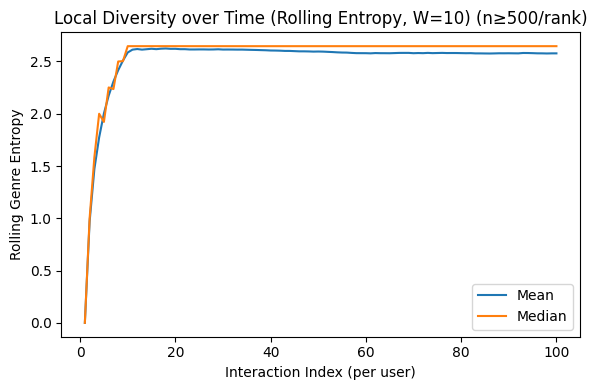

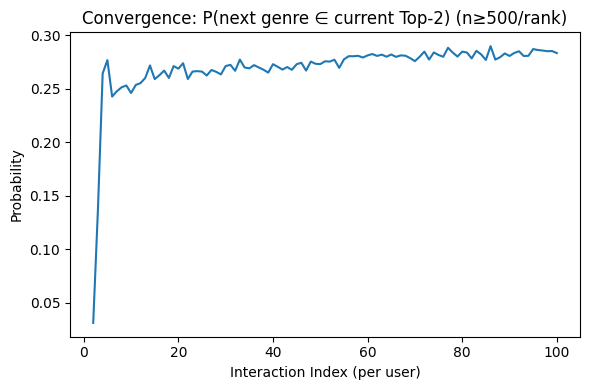

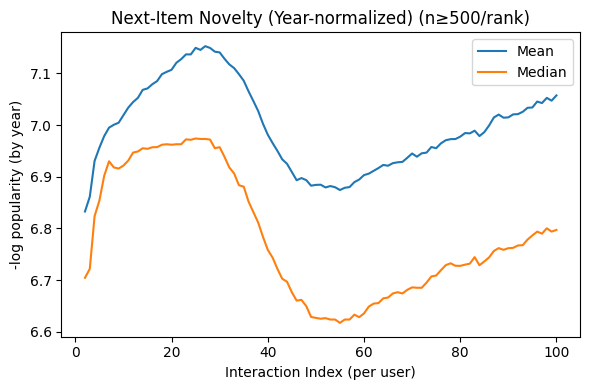

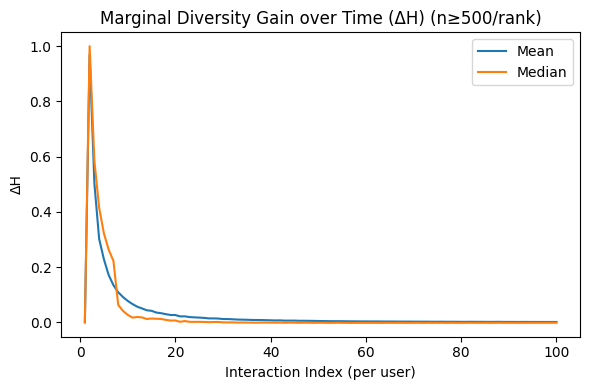

In [26]:
MIN_COUNT = 500

def mask_and_plot(df, xcol, ycols, title, ylabel, fname):
    m = df['count'] >= MIN_COUNT if 'count' in df.columns else np.ones(len(df), dtype=bool)
    plt.figure(figsize=(6,4))
    for yc in ycols:
        plt.plot(df.loc[m, xcol], df.loc[m, yc], label=yc.capitalize() if yc in ['mean','median'] else yc)
    plt.xlabel('Interaction Index (per user)')
    plt.ylabel(ylabel)
    ttl = f"{title}" + (f" (n≥{MIN_COUNT}/rank)" if 'count' in df.columns else "")
    plt.title(ttl)
    if len(ycols)>1: plt.legend()
    plt.tight_layout(); plt.savefig(FIG_DIR/fname, dpi=150); plt.show()

mask_and_plot(roll_agg.rename(columns={'mean':'mean','median':'median','count':'count'}),
              'rank', ['mean','median'],
              f'Local Diversity over Time (Rolling Entropy, W={W})', 'Rolling Genre Entropy',
              f'rolling_entropy_W{W}_masked.png')

mask_and_plot(top2_agg.rename(columns={'mean':'mean','count':'count'}),
              'rank', ['mean'],
              'Convergence: P(next genre ∈ current Top-2)', 'Probability',
              'follow_top2_prob_masked.png')

mask_and_plot(nov_agg.rename(columns={'mean':'mean','median':'median','count':'count'}),
              'rank', ['mean','median'],
              'Next-Item Novelty (Year-normalized)', '-log popularity (by year)',
              'next_item_novelty_year_norm.png')

mask_and_plot(dH_agg.rename(columns={'mean':'mean','median':'median','count':'count'}),
              'rank', ['mean','median'],
              'Marginal Diversity Gain over Time (ΔH)', 'ΔH',
              'delta_entropy_masked.png')

/tmp/ipython-input-2494691411.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ing_all = rf.groupby('userId', group_keys=False).apply(main_genre_next_novelty, W=20)
/tmp/ipython-input-2494691411.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ing_all = rf.groupby('userId', group_keys=False).apply(main_genre_next_novelty, W=20)


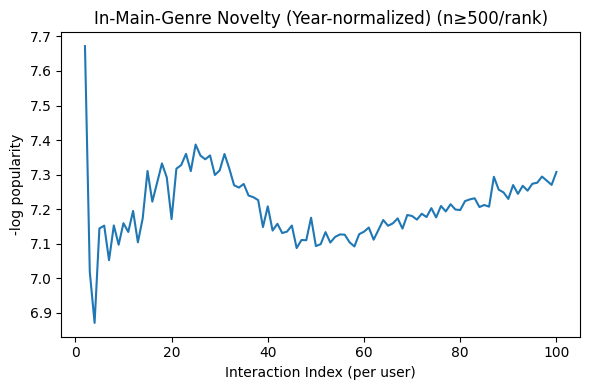

/tmp/ipython-input-2494691411.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rand_all = rf.groupby('userId', group_keys=False).apply(shuffle_top2_baseline, K=2, W=20)


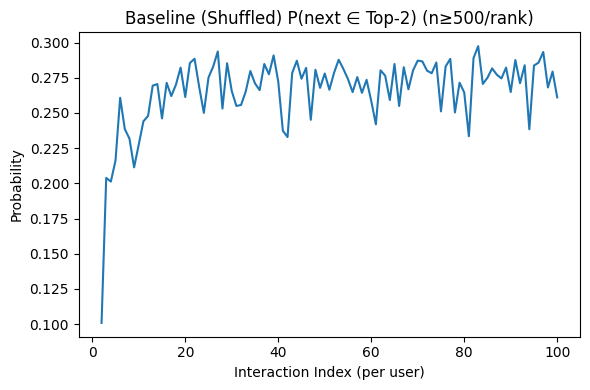

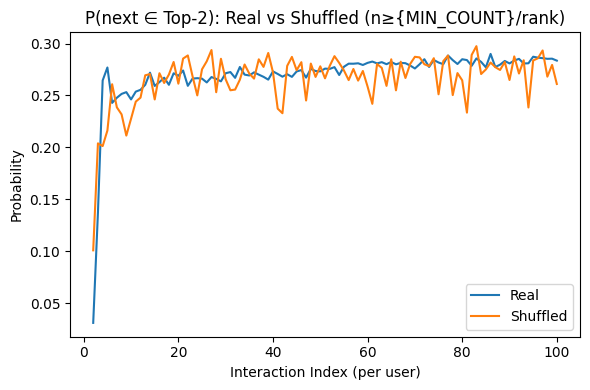

All figures saved to: /content/drive/MyDrive/figs


In [27]:
DO_OPTIONAL = True
if DO_OPTIONAL:
    # 主类型：基于最近 W=20 窗口（不含下一次）
    def main_genre_next_novelty(df_user, W=20):
        out=[]; last_r=df_user['rank'].max(); g_hist=[]
        for r, row in df_user.iterrows():
            rank=row['rank']; g=row['genre_list']; mid=row['movieId']; y=row['year']
            g_hist.append(g)
            if rank<last_r:
                win = g_hist[-W:]
                if not win: continue
                # 主类型
                mg = Counter(win).most_common(1)[0][0]
                nrow = df_user.loc[df_user['rank']==rank+1].iloc[0]
                nmid, ny, ng = nrow['movieId'], nrow['year'], nrow['genre_list']
                # 仅当下一次仍在主类型时，计算其类内新颖度（用全局年内流行度近似）
                if ng == mg:
                    out.append((rank+1, novelty_year(nmid, ny)))
        return pd.DataFrame(out, columns=['rank','novelty_in_main_genre'])

    ing_all = rf.groupby('userId', group_keys=False).apply(main_genre_next_novelty, W=20)
    if len(ing_all):
        ing_agg = ing_all.groupby('rank').agg(mean=('novelty_in_main_genre','mean'),
                                              count=('novelty_in_main_genre','size')).reset_index()
        mask_and_plot(ing_agg.rename(columns={'mean':'mean','count':'count'}),
                      'rank', ['mean'],
                      'In-Main-Genre Novelty (Year-normalized)', '-log popularity',
                      'novelty_in_main_genre_masked.png')

    # 随机基线：打乱每个用户的序列，重算 P(next ∈ Top-2)
    def shuffle_top2_baseline(df_user, K=2, W=20):
        tmp = df_user[['genre_list']].copy().sample(frac=1.0, random_state=123).reset_index(drop=True)
        tmp['rank'] = np.arange(1, len(tmp)+1)
        rows=[]; last_r = tmp['rank'].max(); g_hist=[]
        for r, g in tmp[['rank','genre_list']].itertuples(index=False):
            g_hist.append(g)
            if r<last_r:
                win = g_hist[-W:]; c=Counter(win)
                if not c: rows.append((r+1, np.nan)); continue
                topk = [t for t,_ in c.most_common(K)]
                ng = tmp.loc[tmp['rank']==r+1, 'genre_list'].values[0]
                rows.append((r+1, 1.0 if ng in topk else 0.0))
        return pd.DataFrame(rows, columns=['rank','next_in_top2_rand'])

    rand_all = rf.groupby('userId', group_keys=False).apply(shuffle_top2_baseline, K=2, W=20)
    rand_agg = rand_all.groupby('rank').agg(mean=('next_in_top2_rand','mean'),
                                            count=('next_in_top2_rand','size')).reset_index()

    # 真实 vs 随机（各自遮罩后分别画两张)
    mask_and_plot(rand_agg.rename(columns={'mean':'mean','count':'count'}),
                  'rank', ['mean'],
                  'Baseline (Shuffled) P(next ∈ Top-2)', 'Probability',
                  'follow_top2_prob_baseline_masked.png')

    # 可选：将两条线画在同一张图
    m_real = top2_agg['count']>=MIN_COUNT
    m_rand = rand_agg['count']>=MIN_COUNT
    plt.figure(figsize=(6,4))
    plt.plot(top2_agg.loc[m_real,'rank'], top2_agg.loc[m_real,'mean'], label='Real')
    plt.plot(rand_agg.loc[m_rand,'rank'], rand_agg.loc[m_rand,'mean'], label='Shuffled')
    plt.xlabel('Interaction Index (per user)'); plt.ylabel('Probability')
    plt.title('P(next ∈ Top-2): Real vs Shuffled (n≥{MIN_COUNT}/rank)')
    plt.legend(); plt.tight_layout(); plt.savefig(FIG_DIR/'follow_top2_real_vs_shuffled.png', dpi=150); plt.show()

print("All figures saved to:", FIG_DIR)
